## Lorenz Attractor

## Import packages

In [1]:
import numpy as np
import scipy as sp
from src import py_msent
import matplotlib.pyplot as plt
import fathon
from fathon import fathonUtils as fu
import math
import os
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nolds


## Lorenz attractor: ODEs and phase space

In [8]:
# Create an image of the Lorenz attractor.
# The maths behind this code is described in the scipython blog article
# at https://scipython.com/blog/the-lorenz-attractor/
# Christian Hill, January 2016.
# Updated, January 2021 to use scipy.integrate.solve_ivp.

WIDTH, HEIGHT, DPI = 1000, 750, 100

# Lorenz paramters and initial conditions.
# sigma, beta, rho = 10, 2.667, 28
# u0, v0, w0 = 0, 1, 1.05
sigma, beta, rho = 16, 4, 40
u0, v0, w0 = 1, 1, 1

# Maximum time point and total number of time points.
tmax, n = 500, 20000

def lorenz(t, X, sigma, beta, rho):
    """The Lorenz equations."""
    u, v, w = X
    up = -sigma*(u - v) 
    vp = rho*u - v - u*w 
    wp = -beta*w + u*v 
    return up, vp, wp

# Integrate the Lorenz equations.
soln = solve_ivp(lorenz, (0, tmax), (u0, v0, w0), args=(sigma, beta, rho),
                 dense_output=True)
# Interpolate solution onto the time grid, t.
t = np.linspace(0, tmax, n)
x, y, z = soln.sol(t)

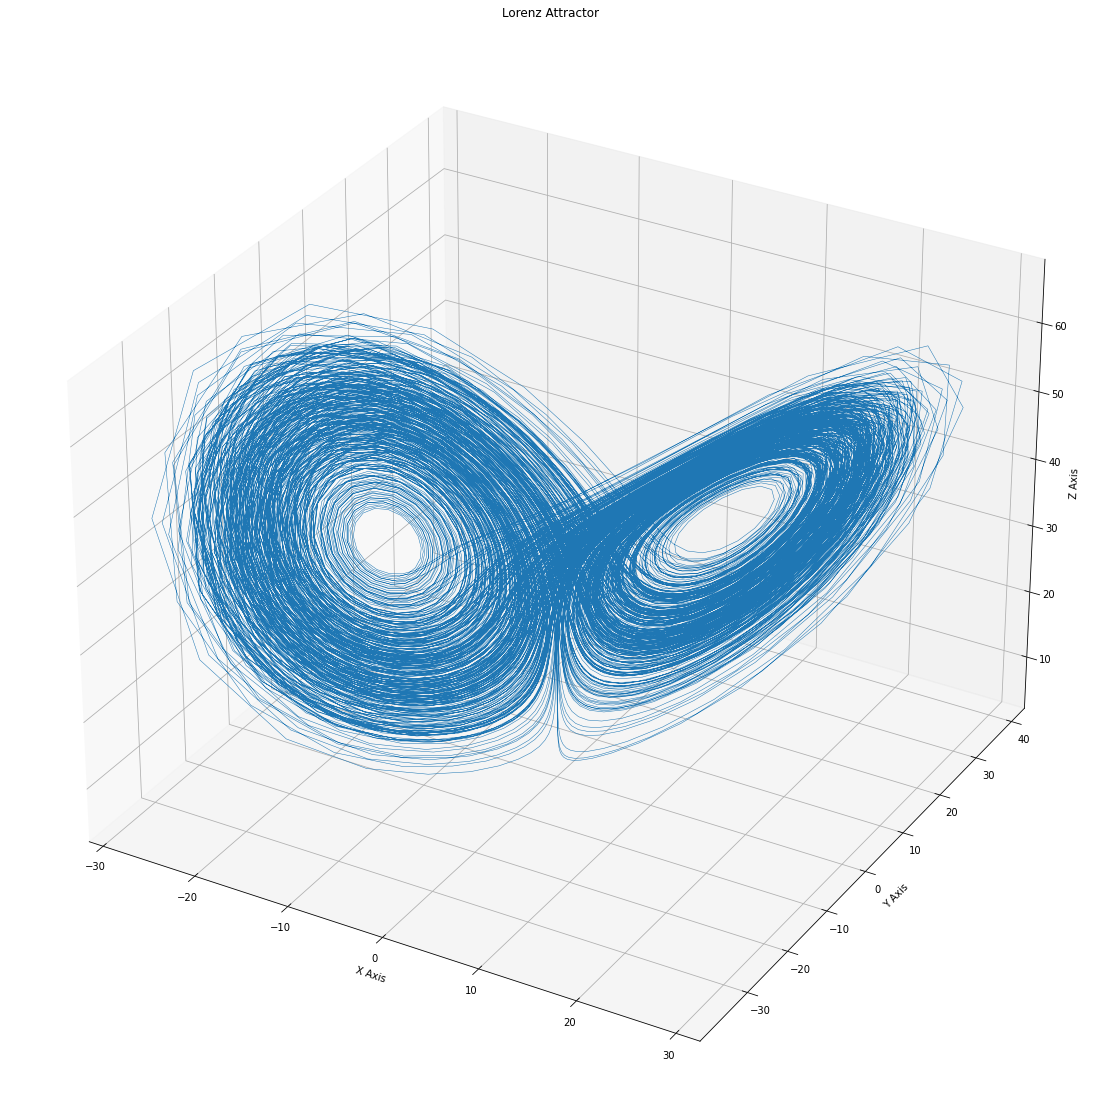

In [9]:
ax = plt.figure(figsize = (20,20)).add_subplot(projection='3d')

ax.plot(x[8000:], y[8000:], z[8000:], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.show()

## Correlation dimension 

The Lorenz attractor is a strange attractor. Therefore, we can compute fractal dimension of the attractor area via correlation dimension. It is expected to be 2.06 according to Procaccia et al. 1983

In [13]:
sd_x= np.std(x, ddof=1)
rvals_vect = nolds.logarithmic_r(0.01 * sd_x, 1.0* sd_x, 1.03)
dim_corr,set_cr = nolds.corr_dim(x,emb_dim=3, rvals=rvals_vect, debug_data=True)

/Users/mariolavanga/Documents/GitHub/nonlinear_signals_analysis/env/lib/python3.7/site-packages/nolds/measures.py:28: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  RuntimeWarning)


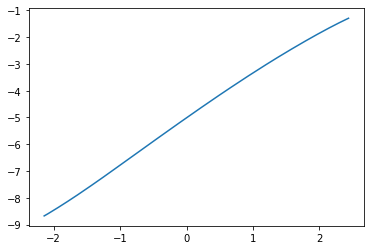

In [14]:
plt.plot(set_cr[0],set_cr[1])

In [15]:
print(dim_corr)

1.6615318308511329


## Lyapunov Exponents

The Lorenz attractor is a chaotic attractor. Therefore, we can compute the lypaunov exponents of the chaotic attractor. 

In [17]:
nolds.lyap_r(x, emb_dim=3)

/Users/mariolavanga/Documents/GitHub/nonlinear_signals_analysis/env/lib/python3.7/site-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 5000
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/mariolavanga/Documents/GitHub/nonlinear_signals_analysis/env/lib/python3.7/site-packages/nolds/measures.py:28: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  RuntimeWarning)


0.05730295589095668

In [18]:
nolds.lyap_e(x, emb_dim=3, matrix_dim=3)

array([ 0.05602185, -0.02999486, -0.7395368 ], dtype=float32)

## Sample Entropy

Estimation of entropy follows the concept of the correlation dimension.

In [19]:
sd_x       = np.std(x, ddof=1)
nolds.sampen(x, emb_dim=3, tolerance= 0.2*sd_x)

0.29674388324439466

## Hurst exponent

Estimation of the Hurst Exponent via Fathon

In [20]:
nMin = 16
nMax = 2**12
nScales = 32
exponents = np.linspace(np.log2(nMin), np.log2(nMax), nScales)
scales = np.round(np.power(2.0, exponents)).astype(np.int64)
q_list = [-5, -3, -1, 1, 3, 5]

In [21]:
def get_idxs(vec, scales):
    idxs = []
    for s in scales:
        idxs.append(np.where(vec==s)[0][0])
    return idxs

In [22]:
def test_mat_dfa_lorenz(x):
    x_dfa = fathon.DFA(fu.toAggregated(x))
    n_w, F_w = x_dfa.computeFlucVec(scales, revSeg=False, polOrd=1)
    idxs = get_idxs(n_w, scales)
    n_w = n_w[idxs]
    F_w = F_w[idxs]
    H, _ = np.polyfit(np.log2(n_w), np.log2(F_w), 1)
    return H,n_w,F_w

In [24]:
H,n_w,F_w = test_mat_dfa_lorenz(x)
print(H)

0.7544970833453518


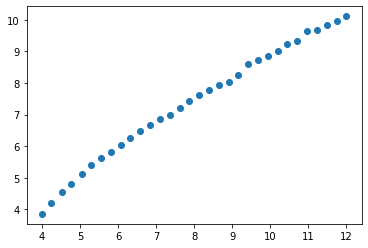

In [25]:
plt.scatter(np.log2(n_w), np.log2(F_w))

Formula according with https://journals.aps.org/pre/abstract/10.1103/PhysRevE.53.5445. However, Hurst exponent is defined 

In [26]:
Hurst_corrdim = 1-dim_corr/2
print(Hurst_corrdim)

0.16923408457443356


Estimation of Hurst via nolds

In [27]:
h = nolds.dfa(x)
print(h)

0.96393242938094


/Users/mariolavanga/Documents/GitHub/nonlinear_signals_analysis/env/lib/python3.7/site-packages/nolds/measures.py:28: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  RuntimeWarning)


## SPECTRUM Slope

In [30]:
from scipy.signal import welch

NSEG     = (n + 1)/50
NSEG_OV  = np.round(NSEG*0.5)
Ts       = tmax/n
fs       = 1/Ts
f,PX = welch(x, fs=fs, window='hann', nperseg=NSEG, noverlap=NSEG_OV, nfft=None)

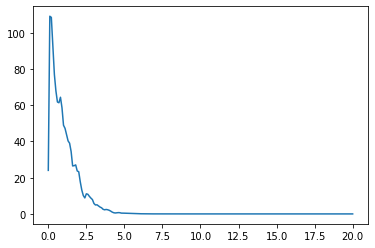

In [59]:
plt.plot(f,PX)

/Users/mariolavanga/Documents/GitHub/nonlinear_signals_analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


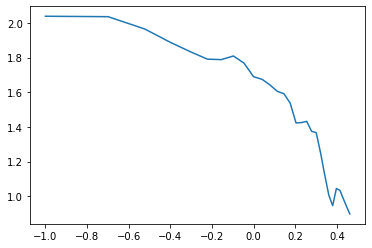

In [49]:
f_loc  = np.where(f<3)[0]
plt.plot(np.log10(f[f_loc]),np.log10(PX[f_loc]))

In [57]:
beta, _ = np.polyfit(np.log10(f[f_loc[1:]]),np.log10(PX[f_loc[1:]]), 1)

-0.8745921759305142

In [60]:
beta_corrdim = 1-dim_corr
print(beta_corrdim)

-0.6615318308511329
